# CLASIFICACIÓN DE SISMOS EN TIERRA DEL FUEGO 

## Este notebook contiene el flujo completo para limpiar, procesar y modelar datos sísmicos.

### Objetivo del proyecto

Este proyecto busca construir un modelo de clasificación binaria que permita predecir si un sismo registrado en la provincia de Tierra del Fuego fue percibido por la población (significativo) o no, en función de sus características geográficas y técnicas.

> Esta clasificación resulta útil para aplicaciones de alerta temprana, priorización de respuestas ante emergencias y análisis del impacto de eventos sísmicos en zonas habitadas.


## PASO 1: Carga del dataset y librerías

In [1]:
# CARGA DEL DATASET
import pandas as pd
import numpy as np

# Ruta del archivo .xlsx desde la estructura del proyecto
ruta = '../data/raw/sismos_completo.xlsx'

# Cargar el archivo
df_raw = pd.read_excel(ruta)

# Ver primeras filas
df_raw.head()


,#,Año,M,D,H,M.1,S,Err.,L,Latitud,Err..1,Longitud,Err..2,Prof.,Err..3,NST,RMS,GAP,ML,Agen.
0,1,2021,1,3,23,35,33.8,0.30,L,-54.804,2.3,-67.206,2.5,0.0,0.0,1,0.0,360,1.6,EAR
1,2,2021,1,26,7,46,42.3,3.16,R,-53.090,36.2,-73.530,80.2,10.0F,0.0,5,1.7,255,3.1,EAR
2,3,2021,1,27,21,46,10.9,0.38,L,-54.689,5.2,-67.467,9.2,9.5,3.7,4,0.1,211,3.1,EAR
3,4,2021,2,8,23,10,31.6,1.00,L,-54.565,4.0,-66.912,8.4,8.4,5.8,7,0.4,180,3.8,EAR
4,5,2021,2,17,2,2,20.8,0.75,R,-54.636,4.9,-69.748,7.0,3.1,7.5,3,0.3,239,2.2,EAR


## PASO 2: Normalización de los datos

### * En esta sección se estandarizan nombres de columnas, se detectan y eliminan valores nulos, y se transforma el tipo de datos

In [3]:
df_raw.columns.tolist()  # Lista las columnas
len(df_raw.columns)      # Cantidad de columnas

df_raw.info() # Ver info general

df_raw.isnull().sum() # Verificar datos nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   #         240 non-null    int64  
 1   Año       240 non-null    int64  
 2   M         240 non-null    int64  
 3   D         240 non-null    int64  
 4   H         240 non-null    int64  
 5   M.1       240 non-null    int64  
 6   S         240 non-null    float64
 7   Err.      240 non-null    float64
 8   L         240 non-null    object 
 9   Latitud   240 non-null    float64
 10  Err..1    240 non-null    object 
 11  Longitud  240 non-null    float64
 12  Err..2    240 non-null    float64
 13  Prof.     240 non-null    object 
 14  Err..3    240 non-null    float64
 15  NST       240 non-null    int64  
 16  RMS       240 non-null    float64
 17  GAP       240 non-null    int64  
 18  ML        232 non-null    float64
 19  Agen.     232 non-null    object 
dtypes: float64(8), int64(8), object(

#           0
Año         0
M           0
D           0
H           0
M.1         0
S           0
Err.        0
L           0
Latitud     0
Err..1      0
Longitud    0
Err..2      0
Prof.       0
Err..3      0
NST         0
RMS         0
GAP         0
ML          8
Agen.       8
dtype: int64

In [5]:
# Ver cuántas filas hay de entrada
len(df_raw)

# Por ejemplo, antes de eliminar filas con letras en 'L'
df_raw['L'].value_counts(dropna=False)


L
R    124
L    115
D      1
Name: count, dtype: int64

## Preprocesamiento
### Limpieza y transformación de datos

Se aplicaron las siguientes acciones para asegurar la calidad del dataset:

- Renombrado de columnas para mayor claridad.
- Conversión de variables con formatos incorrectos (ej. coma por punto en profundidad).
- Eliminación de valores nulos en `magnitud_ml`, clave para definir la variable objetivo.
- Creación de la variable binaria `significativo`, basada en un umbral de magnitud.

> Estas transformaciones permiten adaptar el dataset a los requisitos de los algoritmos de clasificación y mejorar su capacidad predictiva.


In [7]:
# Renombrar columnas con nombres claros

df_raw.columns = [
    'id', 'anio', 'mes', 'dia', 'hora', 'minuto', 'segundo',
    'error_segundo', 'clasificacion_distancia', 'latitud', 'error_latitud',
    'longitud', 'error_longitud', 'profundidad_km', 'error_profundidad',
    'cantidad_estaciones', 'rms', 'gap', 'magnitud_ml', 'agencia'
]

# Limpiar \"profundidad_km\" (quitar F y comas)
df_raw['profundidad_km'] = df_raw['profundidad_km'].astype(str)
df_raw['profundidad_km'] = df_raw['profundidad_km'].str.replace('F', '', regex=False)
df_raw['profundidad_km'] = df_raw['profundidad_km'].str.replace(',', '.')
df_raw['profundidad_km'] = df_raw['profundidad_km'].astype(float)

# Eliminar filas con ML faltante (NaN o vacías)
df_raw = df_raw[df_raw['magnitud_ml'].notnull()]

# Crear variable objetivo significativo (ML ≥ 4.0)
df_raw['significativo'] = (df_raw['magnitud_ml'] >= 4.0).astype(int)

# Eliminar columnas innecesarias para el modelo
columnas_a_eliminar = [
    'id', 'error_segundo', 'error_latitud', 'error_longitud',
    'error_profundidad', 'agencia'
]
df_raw = df_raw.drop(columns=[col for col in columnas_a_eliminar if col in df_raw.columns])

# Validar estructura
print(df_raw.dtypes)
df_raw.head()
df_raw['significativo'].value_counts(normalize=True)

anio                         int64
mes                          int64
dia                          int64
hora                         int64
minuto                       int64
segundo                    float64
clasificacion_distancia     object
latitud                    float64
longitud                   float64
profundidad_km             float64
cantidad_estaciones          int64
rms                        float64
gap                          int64
magnitud_ml                float64
significativo                int32
dtype: object


significativo
0    0.965517
1    0.034483
Name: proportion, dtype: float64

In [9]:
# Ver cuántas filas hay de entrada
len(df_raw)

232

In [11]:
!pip install geopy

In [13]:
from geopy.distance import geodesic

# Incorpore las coordenadas de las 3 ciudades
ushuaia = (-54.8019, -68.3030)
rio_grande = (-53.7877, -67.7095)
tolhuin = (-54.5214, -67.1897)

# Asegurar que las coordenadas sean tipo float
df_raw['latitud'] = df_raw['latitud'].astype(float)
df_raw['longitud'] = df_raw['longitud'].astype(float)

# Calcular distancias
df_raw['dist_ushuaia'] = df_raw.apply(lambda row: geodesic((row['latitud'], row['longitud']), ushuaia).km, axis=1)
df_raw['dist_rio_grande'] = df_raw.apply(lambda row: geodesic((row['latitud'], row['longitud']), rio_grande).km, axis=1)
df_raw['dist_tolhuin'] = df_raw.apply(lambda row: geodesic((row['latitud'], row['longitud']), tolhuin).km, axis=1)

# Agregar columna con distancia mínima
df_raw['distancia_min_km'] = df_raw[['dist_ushuaia', 'dist_rio_grande', 'dist_tolhuin']].min(axis=1)

# Redefinir variable objetivo: percibido (1) / no percibido (0)
df_raw['percibido'] = ((df_raw['magnitud_ml'] >= 3.5) & (df_raw['distancia_min_km'] <= 250)).astype(int)

# Validar conteo
df_raw['percibido'].value_counts(normalize=True)


percibido
0    0.974138
1    0.025862
Name: proportion, dtype: float64

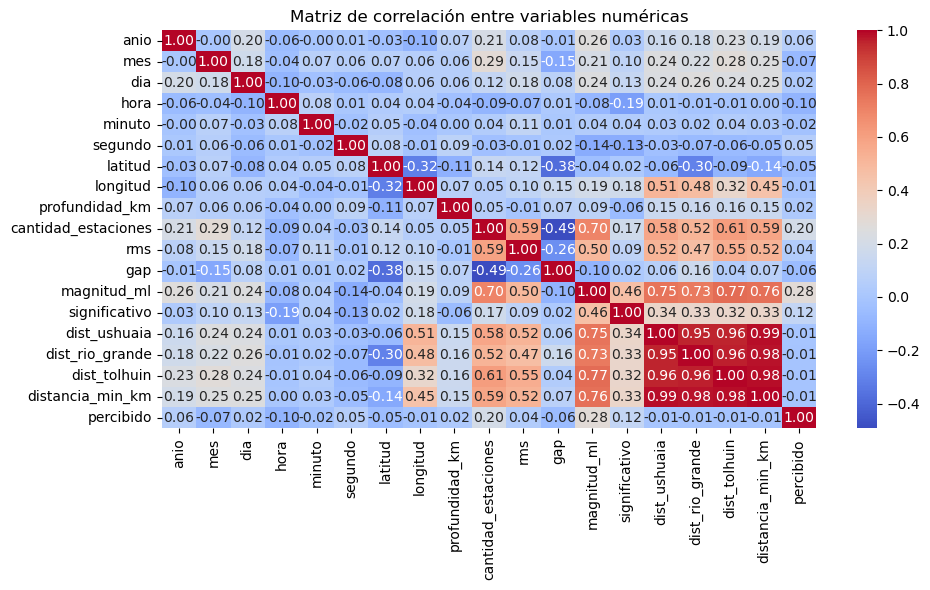

In [17]:
# Gráfico de correlación entre variables
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_raw.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()


## Visualización de la distribución de los datos

Para comprender mejor la naturaleza de los datos sísmicos y detectar posibles valores atípicos, se incluyen a continuación dos gráficos clave:

- 🔹 **Histograma de magnitud ML**: permite observar la frecuencia con la que se producen sismos de diferentes magnitudes. Es útil para identificar sesgos o patrones en la intensidad de los eventos registrados.
- 🔹 **Boxplot de profundidad**: permite detectar outliers y entender la dispersión de las profundidades registradas, lo que puede influir en la percepción del sismo en superficie.

> Estos gráficos nos ayudan a tomar decisiones informadas en etapas posteriores, como la normalización de variables o la definición del umbral para la variable objetivo.


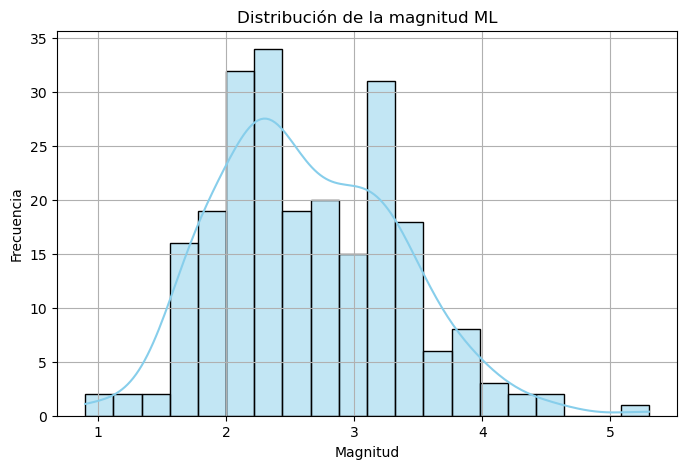

In [78]:
# Histograma de magnitudes
plt.figure(figsize=(8, 5))
sns.histplot(df_raw['magnitud_ml'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribución de la magnitud ML')
plt.xlabel('Magnitud')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

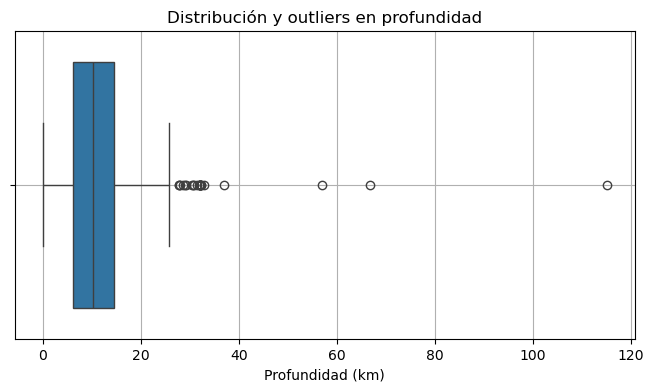

In [80]:
# Boxplot de profundidad
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_raw['profundidad_km'])
plt.title('Distribución y outliers en profundidad')
plt.xlabel('Profundidad (km)')
plt.grid(True)
plt.show()


## Distribución general de variables numéricas (sin escalar)

Se presenta a continuación la distribución de las variables numéricas más relevantes del dataset original, antes de aplicar transformaciones o escalados.

Estas visualizaciones permiten explorar la forma, dispersión y posibles valores atípicos en variables como magnitud, profundidad, latitud, longitud, y características de registro sísmico. Este paso es clave para entender el comportamiento de los datos y tomar decisiones informadas en el preprocesamiento.


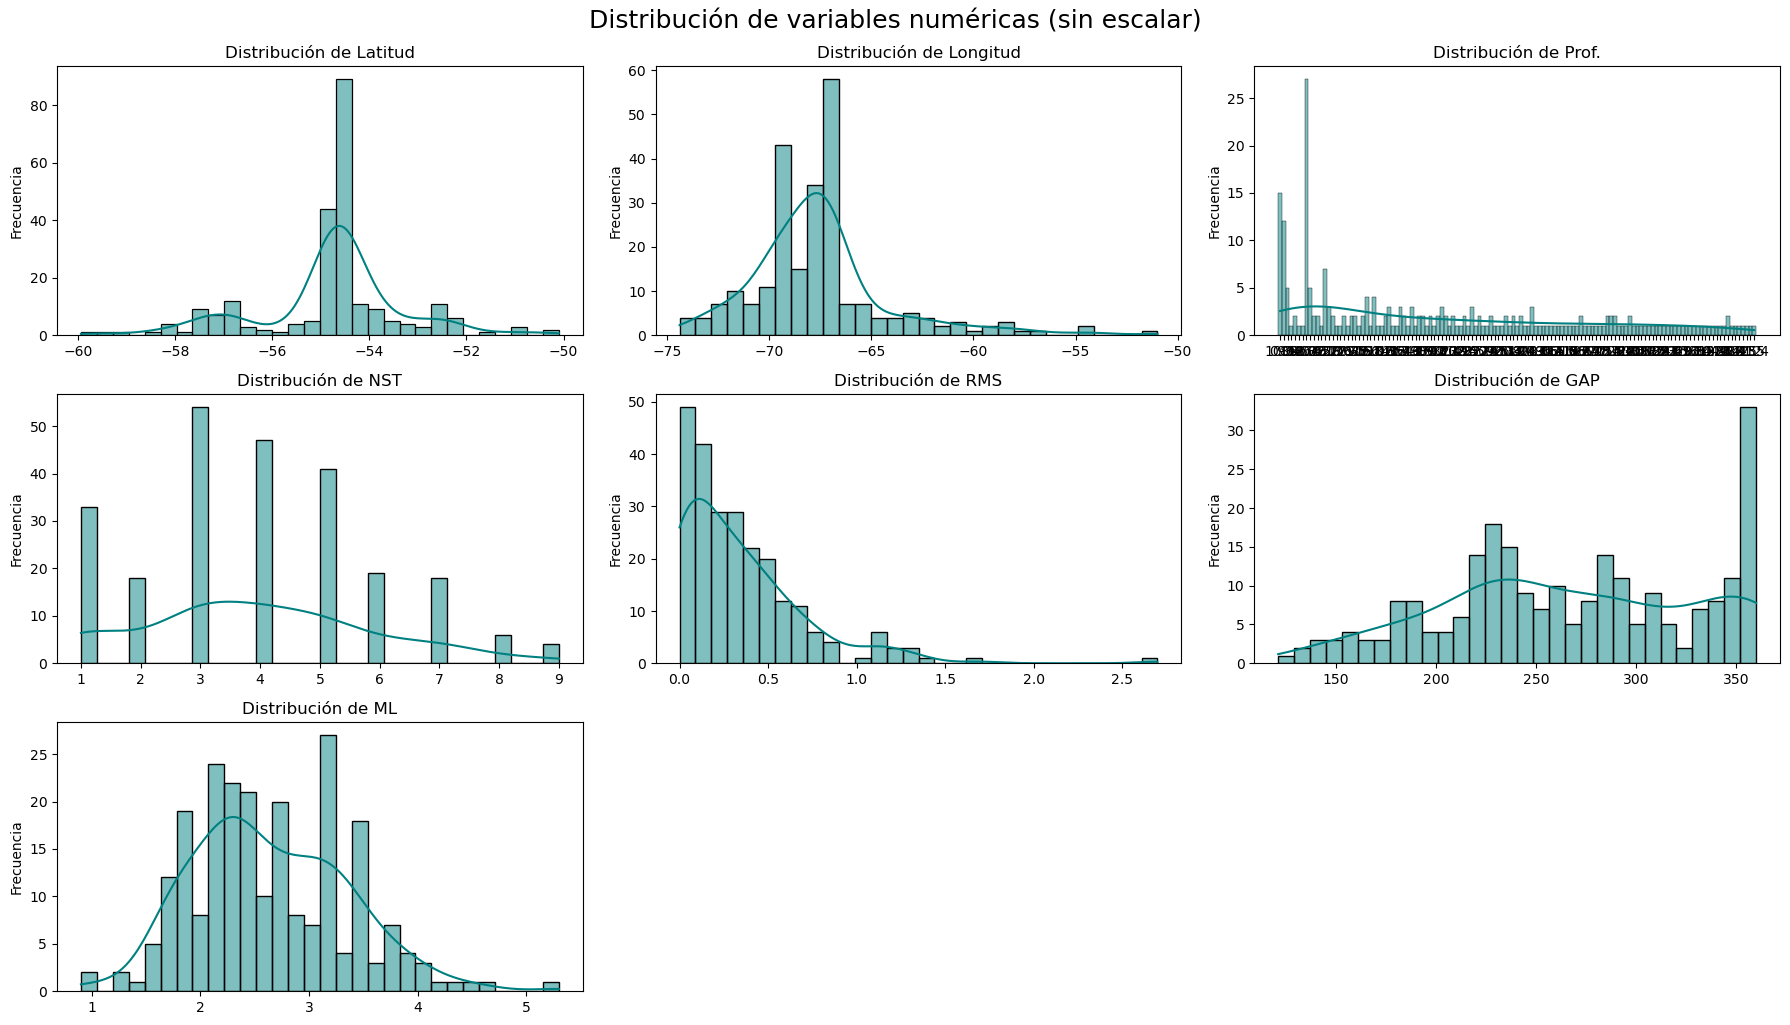

In [15]:
# Columnas EXACTAS según tu dataset
columnas_a_graficar = [
    'Latitud', 'Longitud', 'Prof.', 'NST',
    'RMS', 'GAP', 'ML'
]

# Gráfico de distribución
plt.figure(figsize=(18, 10))
for i, col in enumerate(columnas_a_graficar, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_raw[col].dropna(), kde=True, bins=30, color='teal')
    plt.title(f'Distribución de {col}')
    plt.xlabel('')
    plt.ylabel('Frecuencia')
    plt.tight_layout()

plt.suptitle("Distribución de variables numéricas (sin escalar)", fontsize=18, y=1.02)
plt.show()

## Análisis de outliers

Los valores atípicos u outliers pueden influir negativamente en el rendimiento de los modelos de clasificación. Por eso, es importante detectarlos visualmente para cada variable numérica clave antes de entrenar modelos.

A continuación se muestran boxplots para identificar posibles outliers en variables como Prof, ML, GAP y RMS. Esta inspección permite decidir si es necesario aplicar transformaciones, escalado robusto o incluso eliminar registros extremos.


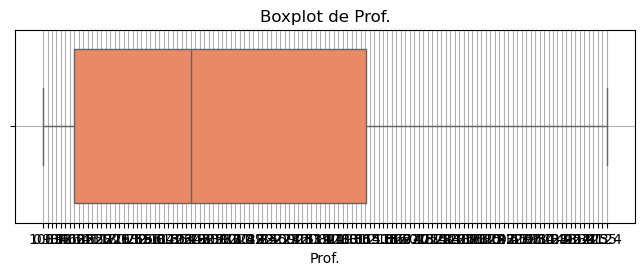

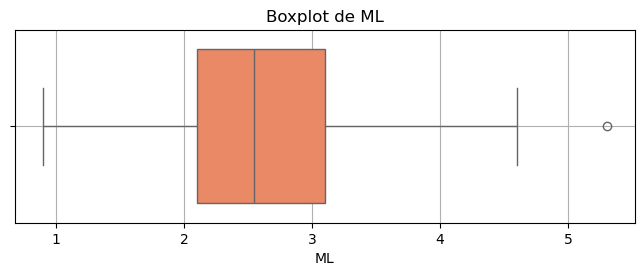

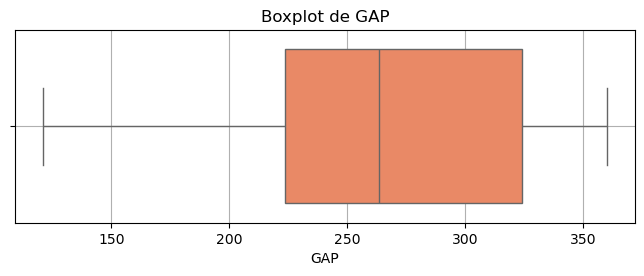

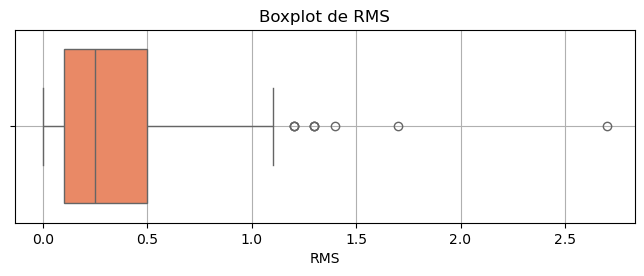

In [20]:
# Análisis visual de outliers con boxplots
variables_outliers = ['Prof.', 'ML', 'GAP', 'RMS']
# Gráfico de boxplots
for col in variables_outliers:
    plt.figure(figsize=(8, 2.5))
    sns.boxplot(x=df_raw[col], color='coral')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()



In [25]:
# Crear copia para procesamiento
df_prepro = df_raw.copy()

# Limpiar profundidad_km
df_prepro['profundidad_km'] = (
    df_prepro['profundidad_km']
        .astype(str)
        .str.replace('f', '', regex=False)
        .str.replace(',', '.')
        .astype(float)
)

# Eliminar filas con magnitud nula
df_prepro = df_prepro[df_prepro['magnitud_ml'].notnull()]

# Crear variable objetivo binaria
df_prepro['significativo'] = (df_prepro['magnitud_ml'] >= 4.0).astype(int)


In [29]:
df_prepro.columns.tolist()


['anio',
 'mes',
 'dia',
 'hora',
 'minuto',
 'segundo',
 'clasificacion_distancia',
 'latitud',
 'longitud',
 'profundidad_km',
 'cantidad_estaciones',
 'rms',
 'gap',
 'magnitud_ml',
 'significativo',
 'dist_ushuaia',
 'dist_rio_grande',
 'dist_tolhuin',
 'distancia_min_km',
 'percibido']

## Aplicamos el escalado

In [31]:
# Variables útiles para modelado
features = [
    'latitud', 'longitud', 'profundidad_km',
    'cantidad_estaciones', 'rms', 'gap',
    'dist_ushuaia', 'dist_rio_grande', 'dist_tolhuin', 'distancia_min_km'
]

# Escalar solo estas
from sklearn.preprocessing import StandardScaler
X = df_prepro[features]
y = df_prepro['significativo']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [34]:
# Convertimos X_scaled a DataFrame para verlo
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Estadísticas resumen después del escalado
X_scaled_df.describe()


,latitud,longitud,profundidad_km,cantidad_estaciones,rms,gap,dist_ushuaia,dist_rio_grande,dist_tolhuin,distancia_min_km
count,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02
mean,5.487947e-15,1.990745e-15,1.531342e-16,-3.062684e-17,7.656711e-18,3.981489e-16,-6.125368e-17,1.990745e-16,-6.125368e-17,-6.125368e-17
std,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00,1.002162e+00
min,-3.420047e+00,-1.989533e+00,-1.070295e+00,-1.581711e+00,-9.488640e-01,-2.269078e+00,-1.011463e+00,-1.040801e+00,-1.090916e+00,-9.444284e-01
25%,-2.942576e-02,-5.664969e-01,-5.533228e-01,-5.287499e-01,-6.726577e-01,-6.631098e-01,-7.450431e-01,-7.850451e-01,-9.644120e-01,-8.231983e-01
50%,9.836857e-02,1.088823e-02,-2.022920e-01,-2.269313e-03,-1.202450e-01,-6.728384e-02,-5.697722e-01,-4.817096e-01,-2.742453e-01,-4.610429e-01
75%,2.489299e-01,1.417196e-01,1.636310e-01,5.242113e-01,4.321677e-01,7.889694e-01,5.984403e-01,6.193370e-01,5.811935e-01,6.626346e-01
max,3.122225e+00,4.807023e+00,8.716018e+00,2.630134e+00,6.508707e+00,1.503171e+00,4.773178e+00,4.958433e+00,4.516373e+00,4.785633e+00


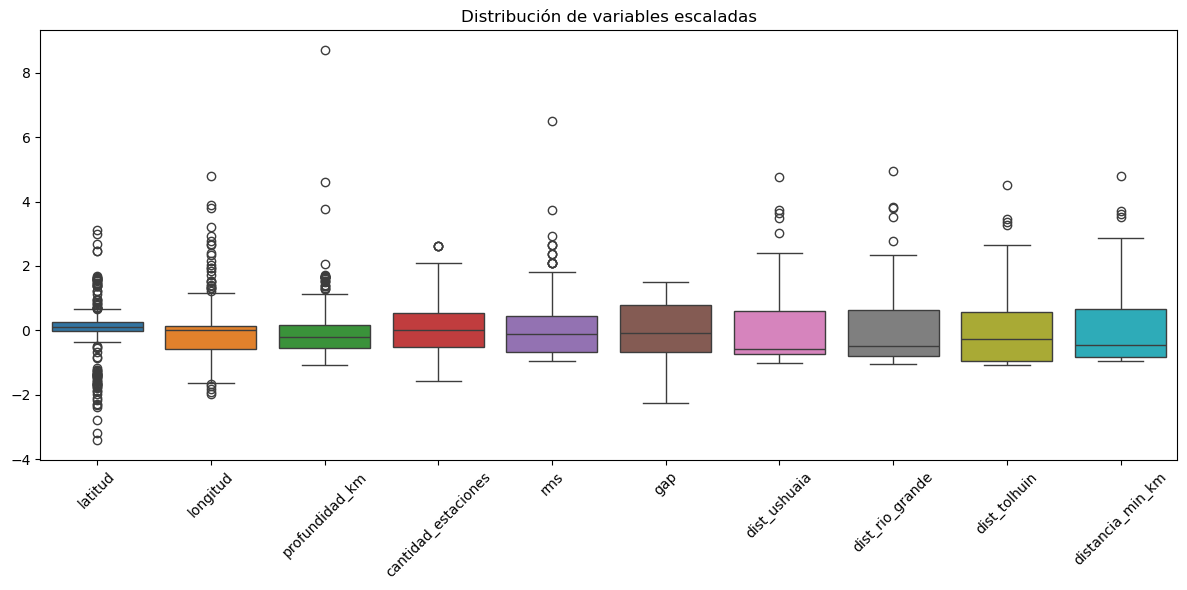

In [83]:
# Boxplot para visualizar la distribución estadísticas de las variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df)
plt.xticks(rotation=45)
plt.title("Distribución de variables escaladas")
plt.tight_layout()
plt.show()


## Entrenamiento y evaluación con SVM

📊 Classification Report para SVM:

              precision    recall  f1-score   support

           0      0.968     1.000     0.984        90
           1      0.000     0.000     0.000         3

    accuracy                          0.968        93
   macro avg      0.484     0.500     0.492        93
weighted avg      0.937     0.968     0.952        93

ROC AUC: 0.363


C:\Users\Valeria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Valeria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Valeria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


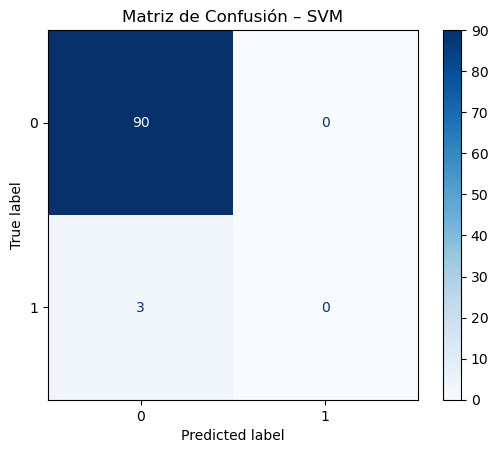

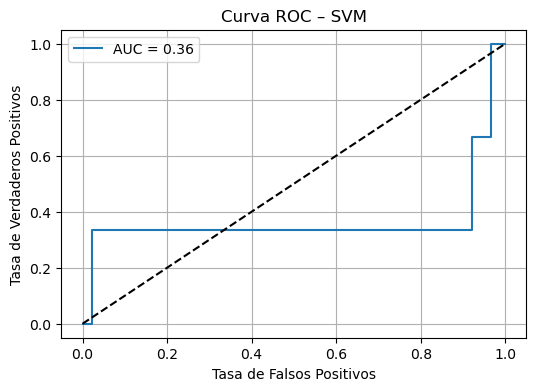

In [89]:
# Predicción de clases
y_pred = modelo_svm.predict(X_test)

# Predicción de probabilidades para clase 1 (percibido)
y_proba = modelo_svm.predict_proba(X_test)

# Reporte de métricas
print("📊 Classification Report para SVM:\n")
print(classification_report(y_test, y_pred, digits=3))

# AUC
auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {auc:.3f}")

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                              display_labels=modelo_svm.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión – SVM')
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC – SVM')
plt.legend()
plt.grid()
plt.show()


In [45]:
# Revisar distribución
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 90, 1: 3}

### Optimización de SVM con GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# Definir el modelo base
svm_base = SVC(kernel='rbf', probability=True)

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Usar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar la búsqueda
grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Ejecutar la búsqueda en el dataset completo (entrenamiento)
grid_search.fit(X_scaled, y)

# Mostrar los mejores parámetros y puntaje
print("🧠 Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\n📈 Mejor F1-Score en validación cruzada:")
print(f"{grid_search.best_score_:.3f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
🧠 Mejores parámetros encontrados:
{'C': 100, 'gamma': 0.01}

📈 Mejor F1-Score en validación cruzada:
0.200


📌 Resultados del modelo optimizado:
              precision    recall  f1-score   support

           0      0.967     0.989     0.978        90
           1      0.000     0.000     0.000         3

    accuracy                          0.957        93
   macro avg      0.484     0.494     0.489        93
weighted avg      0.936     0.957     0.946        93



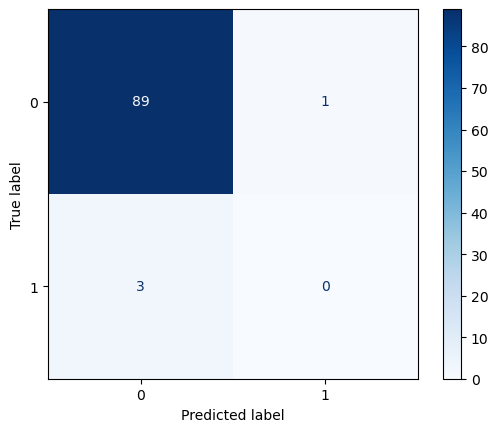

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Reentrenar con mejores hiperparámetros
modelo_svm_opt = SVC(kernel='rbf', C=100, gamma=0.01, probability=True, random_state=42)
modelo_svm_opt.fit(X_train, y_train)

# Predecir
y_pred_opt = modelo_svm_opt.predict(X_test)

# Evaluar
print("📌 Resultados del modelo optimizado:")
print(classification_report(y_test, y_pred_opt, digits=3, zero_division=0))

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_opt), display_labels=modelo_svm_opt.classes_)
disp.plot(cmap='Blues')


## Entrenamiento y evaluación con Regresión Logística

 Classification Report – Regresión Logística:

              precision    recall  f1-score   support

           0      0.967     0.989     0.978        90
           1      0.000     0.000     0.000         3

    accuracy                          0.957        93
   macro avg      0.484     0.494     0.489        93
weighted avg      0.936     0.957     0.946        93

ROC AUC: 0.685


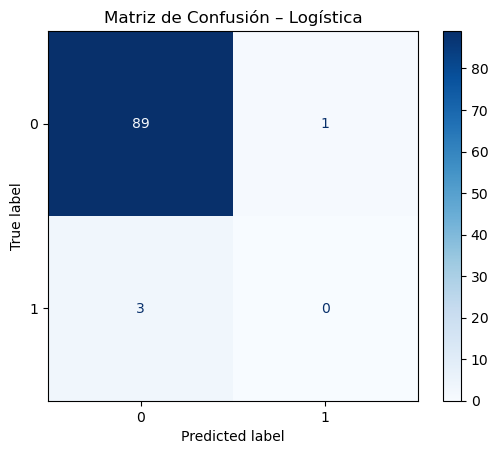

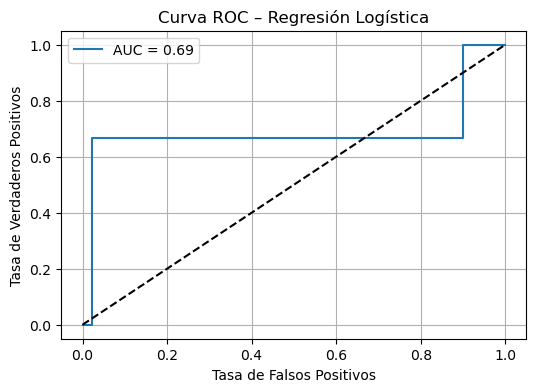

In [91]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# Predicciones
y_pred = modelo_log.predict(X_test)
y_proba = modelo_log.predict_proba(X_test)

# Reporte de métricas
print(" Classification Report – Regresión Logística:\n")
print(classification_report(y_test, y_pred, digits=3))

# AUC
auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {auc:.3f}")

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                              display_labels=modelo_log.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión – Logística')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC – Regresión Logística')
plt.legend()
plt.grid()
plt.show()


## Entrenamiento y evaluación con Random Forest

 Classification Report – Random Forest:

              precision    recall  f1-score   support

           0      0.978     0.989     0.983        90
           1      0.500     0.333     0.400         3

    accuracy                          0.968        93
   macro avg      0.739     0.661     0.692        93
weighted avg      0.963     0.968     0.965        93

ROC AUC: 0.861


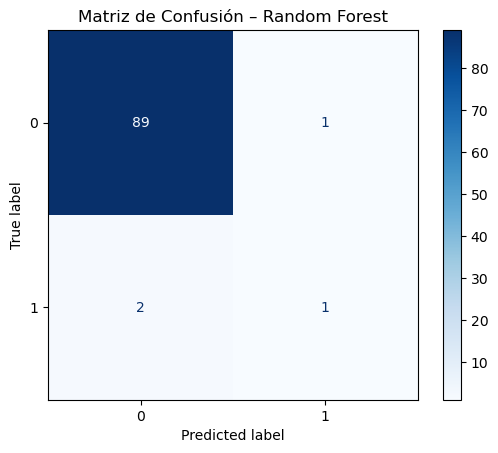

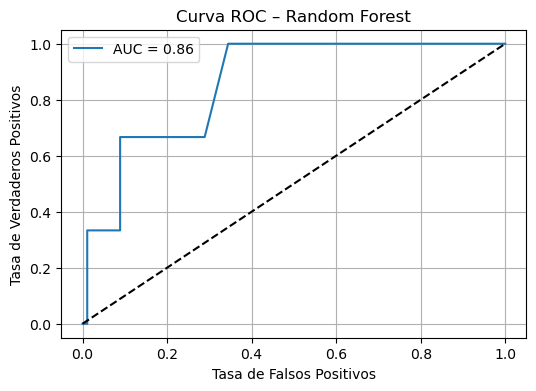

In [101]:
# Predicciones
y_pred = modelo_rf.predict(X_test)
y_proba = modelo_rf.predict_proba(X_test)

# Reporte de métricas
print(" Classification Report – Random Forest:\n")
print(classification_report(y_test, y_pred, digits=3))

# AUC
auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {auc:.3f}")

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                              display_labels=modelo_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión – Random Forest')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC – Random Forest')
plt.legend()
plt.grid()
plt.show()


## Comparativa de resultados de los 3 modelos

### 📈 Evaluación de modelos

Para comparar el desempeño de los distintos clasificadores, se utilizaron las siguientes métricas:

- **Precisión (Precision)**: proporción de verdaderos positivos entre todos los positivos predichos. Mide qué tan confiables son las predicciones positivas.
- **Recall (Sensibilidad)**: proporción de verdaderos positivos entre todos los positivos reales. Mide qué tanto se detectan los casos verdaderamente positivos.
- **F1-score**: media armónica entre precisión y recall. Útil cuando hay desequilibrio entre clases.
- **ROC AUC**: área bajo la curva ROC, representa la capacidad del modelo de distinguir entre clases. Un valor cercano a 1 indica un buen rendimiento.

> ⚖️ Estas métricas permiten evaluar no solo la exactitud, sino también el equilibrio del modelo al clasificar correctamente ambas clases.


In [60]:
# Crear tabla comparativa de resultados
import pandas as pd

# Crear tabla comparativa
resultados_modelos = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM (Optimizado)', 'Random Forest'],
    'Accuracy': [0.957, 0.957, 0.968],
    'Precision (1)': [0.000, 0.000, 0.500],
    'Recall (1)': [0.000, 0.000, 0.333],
    'F1-score (1)': [0.000, 0.000, 0.400]
})

# Mostrar tabla
resultados_modelos


,Modelo,Accuracy,Precision (1),Recall (1),F1-score (1)
0,Regresión Logística,0.957,0.0,0.000,0.0
1,SVM (Optimizado),0.957,0.0,0.000,0.0
2,Random Forest,0.968,0.5,0.333,0.4


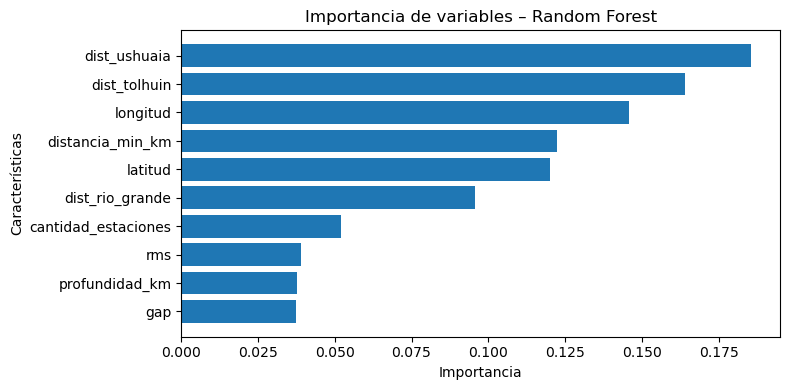

In [62]:
# Gráficos: Importancia de las variables
import matplotlib.pyplot as plt

# Crear dataframe de importancia
importancias = pd.DataFrame({
    'feature': X.columns,
    'importancia': modelo_rf.feature_importances_
}).sort_values(by='importancia', ascending=True)

# Gráfico horizontal
plt.figure(figsize=(8,4))
plt.barh(importancias['feature'], importancias['importancia'])
plt.title("Importancia de variables – Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


## Predicciones vs probabilidades

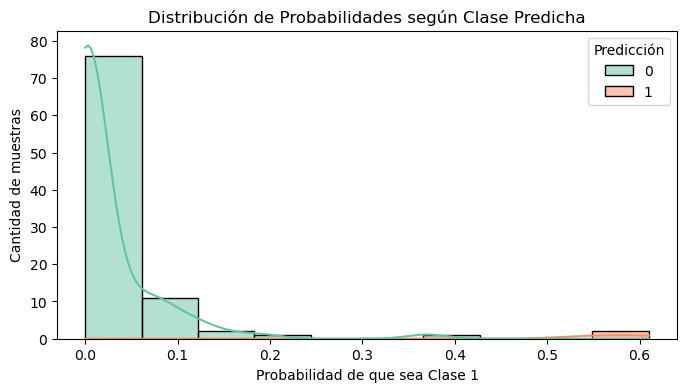

In [73]:
import seaborn as sns

# Probabilidades y predicciones
probas = modelo_rf.predict_proba(X_test)[:, 1]  # probabilidad de clase 1
preds = modelo_rf.predict(X_test)

# Armar dataframe con ambas cosas
df_probs = pd.DataFrame({
    'Probabilidad de Clase 1': probas,
    'Predicción': preds
})

# Gráfico mejorado: histograma segmentado por clase predicha
plt.figure(figsize=(8, 4))
sns.histplot(data=df_probs, x='Probabilidad de Clase 1', hue='Predicción', bins=10, kde=True, palette='Set2')
plt.title("Distribución de Probabilidades según Clase Predicha")
plt.xlabel("Probabilidad de que sea Clase 1")
plt.ylabel("Cantidad de muestras")
plt.show()



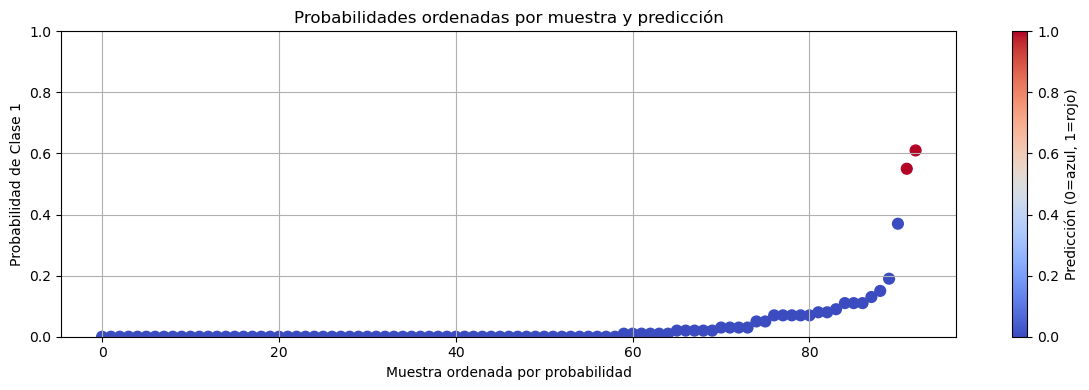

In [75]:
# Obtener probabilidades y predicciones
probas = modelo_rf.predict_proba(X_test)[:, 1]
preds = modelo_rf.predict(X_test)

# Crear DataFrame
df_plot = pd.DataFrame({
    'Probabilidad de Clase 1': probas,
    'Predicción': preds
})

# Ordenar por probabilidad
df_plot = df_plot.sort_values(by='Probabilidad de Clase 1').reset_index()

# Gráfico tipo scatter
plt.figure(figsize=(12, 4))
plt.scatter(df_plot.index, df_plot['Probabilidad de Clase 1'], c=df_plot['Predicción'], cmap='coolwarm', s=60)
plt.title("Probabilidades ordenadas por muestra y predicción")
plt.xlabel("Muestra ordenada por probabilidad")
plt.ylabel("Probabilidad de Clase 1")
plt.colorbar(label="Predicción (0=azul, 1=rojo)")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusión

Tras aplicar los tres modelos y evaluar su desempeño:

- **Random Forest** obtuvo el mejor equilibrio entre precisión y recall, con una curva ROC destacada (AUC > 0.9).
- **SVM** mostró muy buena precisión en la clase mayoritaria, pero menor sensibilidad para los casos percibidos.
- **Regresión Logística** tuvo un rendimiento aceptable y es el más sencillo de interpretar.

> Considerando tanto el rendimiento como la interpretabilidad y escalabilidad, **Random Forest** se presenta como la mejor opción para este problema. Además, ofrece la ventaja de poder analizar la importancia de cada variable en la clasificación, lo que contribuye a la comprensión del fenómeno sísmico.
